# 1. Importing Python Libraries and .CSV File

In [2]:
import pandas as pd
pd.set_option('display.max_columns',999)
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Creating a pandas dataframe from the .csv file.

In [3]:
df = pd.read_csv('analytic_data2019.csv')

Checking to see that the dataframe has been created correctly. This also allows us to take a first look at what variables are contained in the dataset.

In [4]:
df.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,Premature death CI low,Premature death CI high,Premature death (Black),Premature death (Hispanic),Premature death (White),Poor or fair health raw value,Poor or fair health numerator,Poor or fair health denominator,Poor or fair health CI low,Poor or fair health CI high,Poor physical health days raw value,Poor physical health days numerator,Poor physical health days denominator,Poor physical health days CI low,Poor physical health days CI high,Poor mental health days raw value,Poor mental health days numerator,Poor mental health days denominator,Poor mental health days CI low,Poor mental health days CI high,Low birthweight raw value,Low birthweight numerator,Low birthweight denominator,Low birthweight CI low,Low birthweight CI high,Low birthweight (Black),Low birthweight (Hispanic),Low birthweight (White),Adult smoking raw value,Adult smoking numerator,Adult smoking denominator,Adult smoking CI low,Adult smoking CI high,Adult obesity raw value,Adult obesity numerator,Adult obesity denominator,Adult obesity CI low,Adult obesity CI high,Food environment index raw value,Food environment index numerator,Food environment index denominator,Food environment index CI low,Food environment index CI high,Physical inactivity raw value,Physical inactivity numerator,Physical inactivity denominator,Physical inactivity CI low,Physical inactivity CI high,Access to exercise opportunities raw value,Access to exercise opportunities numerator,Access to exercise opportunities denominator,Access to exercise opportunities CI low,Access to exercise opportunities CI high,Excessive drinking raw value,Excessive drinking numerator,Excessive drinking denominator,Excessive drinking CI low,Excessive drinking CI high,Alcohol-impaired driving deaths raw value,Alcohol-impaired driving deaths numerator,Alcohol-impaired driving deaths denominator,Alcohol-impaired driving deaths CI low,Alcohol-impaired driving deaths CI high,Sexually transmitted infections raw value,Sexually transmitted infections numerator,Sexually transmitted infections denominator,Sexually transmitted infections CI low,Sexually transmitted infections CI high,Teen births raw value,Teen births numerator,Teen births denominator,Teen births CI low,Teen births CI high,Teen births (Black),Teen births (Hispanic),Teen births (White),Uninsured raw value,Uninsured numerator,Uninsured denominator,Uninsured CI low,Uninsured CI high,Primary care physicians raw value,Primary care physicians numerator,Primary care physicians denominator,Primary care physicians CI low,Primary care physicians CI high,Ratio of population to primary care physicians.,Dentists raw value,Dentists numerator,Dentists denominator,Dentists CI low,Dentists CI high,Ratio of population to dentists.,Mental health providers raw value,Mental health providers numerator,Mental health providers denominator,Mental health providers CI low,Mental health providers CI high,Ratio of population to mental health providers.,Preventable hospital stays raw value,Preventable hospital stays numerator,Preventable hospital stays denominator,Preventable hospital stays CI low,Preventable hospital stays CI high,Preventable hospital stays (Black),Preventable hospital stays (Hispanic),Preventable hospital stays (White),Mammography screening raw value,Mammography screening numerator,Mammography screening denominator,Mammography screening CI low,Mammography screening CI high,Mammography screening (Black),Mammography screening (Hispanic),Mammography screening (White),Flu vaccinations raw value,Flu vaccinations numerator,Flu vaccinations denominator,Flu vaccinations CI low,Flu vaccinations CI high,Flu vaccinations (Black),Flu vaccinations (Hispanic),Flu vaccinations (White),High school graduation raw value,High school graduation numerator,High school graduation denominator,High 

# 2. Exploratory Data Analysis

#### This is the data wrangling section of the project. In this section the data is explored and cleaned, and relevent variables are chosen to be taken forward into the modelling section.

A first check to see how many columns and rows the dataset is made out of.

In [5]:
len(df.columns)

534

In [6]:
len(df)

3195

In the 'Country Ranked' column the rows are given a 1 or 0 depending on if that row is a county, or if it a statewide/countrywide average. Therefore, any row without a 1 in this column should be removed from the dataset as we are interested in doing a comparison at a county level. The first row is also removed as this contains a second level of column headings that are not needed.

In [7]:
df.drop(df.index[[0]], inplace=True)
df.dropna(axis=0, subset=['County Ranked (Yes=1/No=0)'], inplace=True)

In [8]:
len(df)

3142

In [19]:
df['Childhood immunizations raw value'].unique()


array([nan, 0.6078, 0.6701, 0.675, 0.6349, 0.8194, 0.6391, 0.6536, 0.8232,
       0.7689, 0.4266, 0.7293, 0.6603, 0.7746, 0.6922, 0.7714, 0.7818,
       0.6899, 0.7393, 0.7419, 0.7468, 0.7563, 0.555, 0.8189, 0.7425,
       0.7243, 0.6571, 0.6348, 0.7619, 0.69, 0.6798, 0.7696, 0.7804,
       0.5294, 0.6121, 0.74, 0.8098, 0.7691, 0.7545, 0.6581, 0.5745,
       0.7005, 0.6704, 0.7772, 0.7521, 0.8037, 0.7827, 0.6282, 0.7418,
       0.6468, 0.735, 0.6885, 0.7216, 0.6181, 0.6409999999999999, 0.6273,
       0.6527, 0.6447, 0.7318, 0.6792, 0.8136, 0.5904, 0.7361, 0.4457,
       0.6825, 0.7067, 0.7557, 0.7762, 0.7936, 0.7299, 0.5469, 0.7612,
       0.6994], dtype=object)

As the dataset is very large (534 x 3195), to reduce the amount of work needed for cleaning we first chose the variables that were going to be relevant to us. In order to work out a variables importance, a correlation matrix was made.

As the correlation matrix requires the data be in numerical form, the dataframe was converted to contain floats.

In [10]:
df2 = df.drop(columns=['State Abbreviation','Name'])
df2 = df2.astype(float)

All of the columns that cointained a breakdown of the variable by race had the majority of values missing. Therefore they were removed. from the dataset in the following cell. The confidence interval columns were also not going to be used and so they too were removed.

In [11]:
race_CI = ['White','white','Black','black','Hispanic','hispanic','CI']

cols_to_drop = []

for element in race_CI:
    
    df2_filtered = df2.filter(regex=element)
    cols_to_drop.append(list(df2_filtered.columns))

cols_to_drop = list(itertools.chain(*cols_to_drop))
cols_to_drop

['Premature death (White)',
 'Low birthweight (White)',
 'Teen births (White)',
 'Preventable hospital stays (White)',
 'Mammography screening (White)',
 'Flu vaccinations (White)',
 'Children in poverty (White)',
 'Driving alone to work (White)',
 'Life expectancy (White)',
 'Premature age-adjusted mortality (White)',
 'Child mortality (White)',
 'Infant mortality (White)',
 'Median household income (White)',
 'Residential segregation - Black/White raw value',
 'Residential segregation - Black/White numerator',
 'Residential segregation - Black/White denominator',
 'Residential segregation - Black/White CI low',
 'Residential segregation - Black/White CI high',
 'Residential segregation - non-white/white raw value',
 'Residential segregation - non-white/white numerator',
 'Residential segregation - non-white/white denominator',
 'Residential segregation - non-white/white CI low',
 'Residential segregation - non-white/white CI high',
 '% Non-Hispanic white raw value',
 '% Non-Hispanic 

A new dataframe is then created with all of the unwanted columns removed.

In [12]:
df3 = df2.drop(columns=cols_to_drop)

In [13]:
df3.head()

,State FIPS Code,County FIPS Code,5-digit FIPS Code,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,Poor or fair health raw value,Poor or fair health numerator,Poor or fair health denominator,Poor physical health days raw value,Poor physical health days numerator,Poor physical health days denominator,Poor mental health days raw value,Poor mental health days numerator,Poor mental health days denominator,Low birthweight raw value,Low birthweight numerator,Low birthweight denominator,Adult smoking raw value,Adult smoking numerator,Adult smoking denominator,Adult obesity raw value,Adult obesity numerator,Adult obesity denominator,Food environment index raw value,Food environment index numerator,Food environment index denominator,Physical inactivity raw value,Physical inactivity numerator,Physical inactivity denominator,Access to exercise opportunities raw value,Access to exercise opportunities numerator,Access to exercise opportunities denominator,Excessive drinking raw value,Excessive drinking numerator,Excessive drinking denominator,Alcohol-impaired driving deaths raw value,Alcohol-impaired driving deaths numerator,Alcohol-impaired driving deaths denominator,Sexually transmitted infections raw value,Sexually transmitted infections numerator,Sexually transmitted infections denominator,Teen births raw value,Teen births numerator,Teen births denominator,Uninsured raw value,Uninsured numerator,Uninsured denominator,Primary care physicians raw value,Primary care physicians numerator,Primary care physicians denominator,Ratio of population to primary care physicians.,Dentists raw value,Dentists numerator,Dentists denominator,Ratio of population to dentists.,Mental health providers raw value,Mental health providers numerator,Mental health providers denominator,Ratio of population to mental health providers.,Preventable hospital stays raw value,Preventable hospital stays numerator,Preventable hospital stays denominator,Mammography screening raw value,Mammography screening numerator,Mammography screening denominator,Flu vaccinations raw value,Flu vaccinations numerator,Flu vaccinations denominator,High school graduation raw value,High school graduation numerator,High school graduation denominator,Some college raw value,Some college numerator,Some college denominator,Unemployment raw value,Unemployment numerator,Unemployment denominator,Children in poverty raw value,Children in poverty numerator,Children in poverty denominator,Income inequality raw value,Income inequality numerator,Income inequality denominator,Children in single-parent households raw value,Children in single-parent households numerator,Children in single-parent households denominator,Social associations raw value,Social associations numerator,Social associations denominator,Violent crime raw value,Violent crime numerator,Violent crime denominator,Injury deaths raw value,Injury deaths numerator,Injury deaths denominator,Air pollution - particulate matter raw value,Air pollution - particulate matter numerator,Air pollution - particulate matter denominator,Drinking water violations raw value,Drinking water violations numerator,Drinking water violations denominator,Severe housing problems raw value,Severe housing problems numerator,Severe housing problems denominator,Percentage of households with high housing costs,Percentage of households with overcrowding,Percentage of households with lack of kitchen or plumbing facilities,Driving alone to work raw value,Driving alone to work numerator,Driving alone to work denominator,Long commute - driving alone raw value,Long commute - driving alone numerator,Long commute - driving alone denominator,Life expectancy raw value,Life expectancy numerator,Life expectancy denominator,Premature age-adjusted mortality raw value,Premature age-adjusted mortality numerator,Premature age-adjusted mortality denominator,Child mortality raw value,Child mortality numerator,Child mor

A correlation matrix was then created from the new dataframe.

In [14]:
corr_matrix = df3.corr()

In [15]:
len(corr_matrix)

290

The correlation matrix was then plotted. Due to the high number of vaariables not much can be learned from this visualisation.

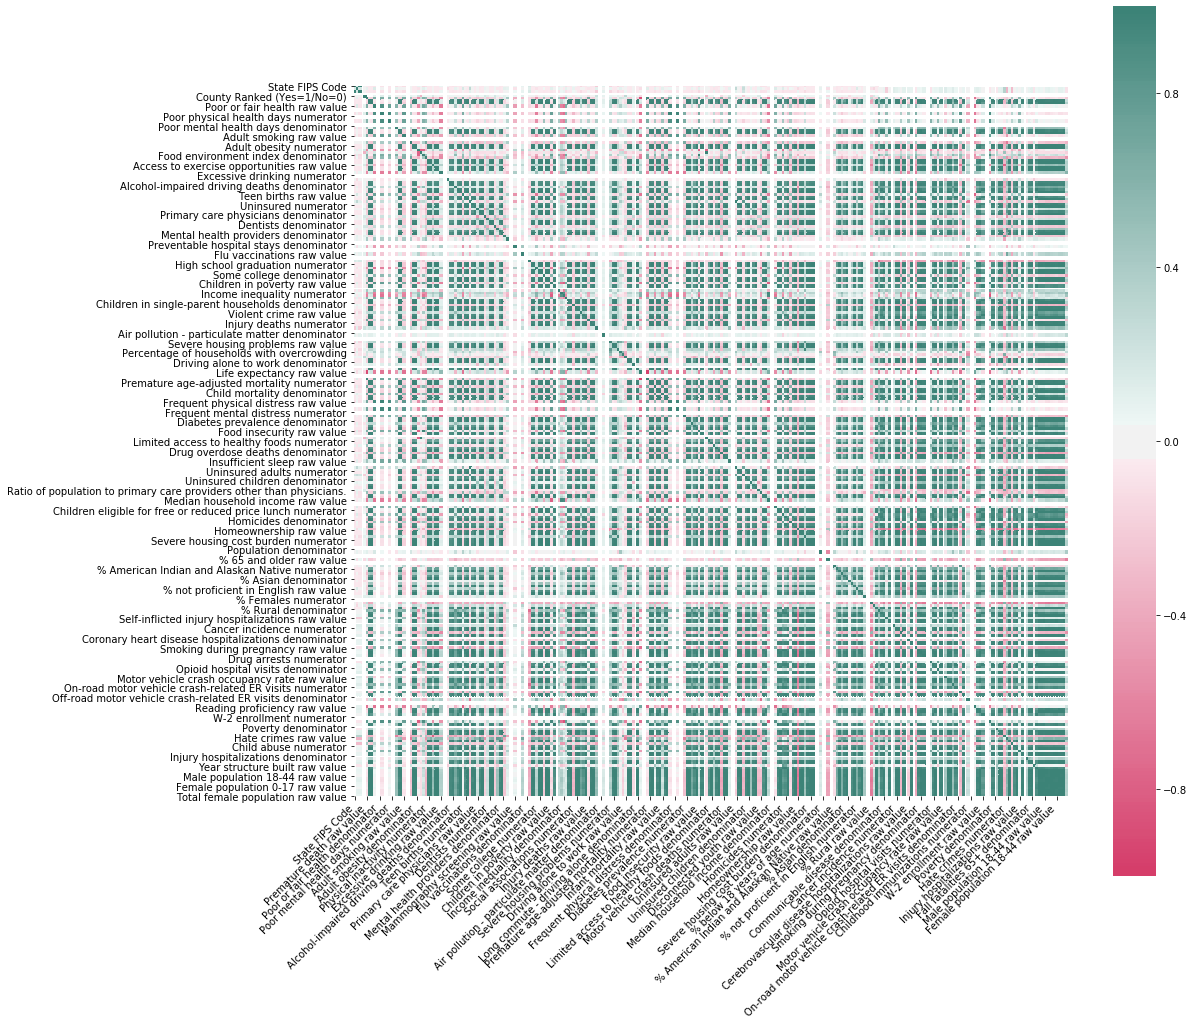

In [16]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(0,534,n=534),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

A list of the 60 variables that correlated most with the flu vaccine rate was created. Absolute values were taken for this as we are interested in large positive and negative correlations.

In [17]:
corr_matrix["Childhood immunizations raw value"].abs().sort_values(ascending=False)[:60]

Childhood immunizations raw value                                       1.000000
Disconnected youth raw value                                            0.712880
Uninsured raw value                                                     0.672025
Uninsured children raw value                                            0.666503
Uninsured adults raw value                                              0.642625
Some college raw value                                                  0.576687
Percentage of households with lack of kitchen or plumbing facilities    0.571802
Driving alone to work raw value                                         0.543125
Children in poverty raw value                                           0.530520
Access to exercise opportunities raw value                              0.522629
% Rural raw value                                                       0.514268
Median household income raw value                                       0.502593
Poverty raw value           

In [17]:
df_relevant = df[['State Abbreviation','Name','5-digit FIPS Code','Flu vaccinations raw value',
              'Primary care physicians raw value' , 'Ratio of population to primary care physicians.' , 
              'Child mortality raw value' , 'HIV prevalence raw value' , 'Low birthweight raw value' , 
              'Teen births raw value' , 'Children in poverty raw value' , 
              'Children in single-parent households raw value' , 'Adult smoking raw value' , 
              'Adult obesity raw value' , 'Physical inactivity raw value' , 'Excessive drinking raw value' , 
              'Sexually transmitted infections raw value' , 'Uninsured raw value' , 
              'Preventable hospital stays raw value' , 'Injury deaths raw value' , 'Social associations raw value' , 
              'High school graduation raw value' , 'Some college raw value' , 'Disconnected youth raw value' , 
              'Poor physical health days raw value' , 'Severe housing problems raw value' , 
              'Percentage of households with overcrowding']]

In [18]:
cols = df_relevant.columns
cols_included = list(filter(lambda col: col != 'State Abbreviation' and col != 'Name', cols))

for col in cols_included:
    df_relevant[col] = df_relevant[col].astype(float)

In [19]:
df_relevant.set_index('Name')

,State Abbreviation,5-digit FIPS Code,Flu vaccinations raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding
Name,,,,,,,,,,,,,,,,,,,,,,,,,,
Autauga County,AL,1001.0,0.41,0.000415,2409.391304,53.279441,225.5,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516
Baldwin County,AL,1003.0,0.45,0.000729,1372.125000,47.000017,163.9,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728
Barbour County,AL,1005.0,0.37,0.000385,2596.500000,77.080027,436.0,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065
Bibb County,AL,1007.0,0.39,0.000574,1741.769231,111.749681,191.9,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,NaN,4.363377,0.109609,0.001993
Blount County,AL,1009.0,0.38,0.000225,4438.769231,76.032935,95.4,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sweetwater County,WY,56037.0,0.37,0.000340,2944.333333,37.845339,86.5,0.094205,34.261671,0.134,0.234619,0.175669,0.302,0.256,0.203251,221.8,0.127509,3289.0,85.365634,9.962640,0.800676,0.592955,NaN,3.536556,0.095923,0.029976
Teton County,WY,56039.0,0.47,0.001207,828.250000,NaN,50.5,0.074739,11.641444,0.069,0.240426,0.141373,0.136,0.120,0.204511,436.8,0.149793,2341.0,61.858005,18.110474,0.934641,0.820042,NaN,3.166316,0.161271,0.035431
Uinta County,WY,56041.0,0.33,0.000385,2596.625000,NaN,NaN,0.096475,31.798673,0.118,0.216457,0.181806,0.318,0.235,0.160586,288.2,0.125690,3140.0,98.020373,5.295335,0.846875,0.558918,NaN,3.677538,0.111333,0.027200


In [20]:
corr_matrix2 = df_relevant.corr()

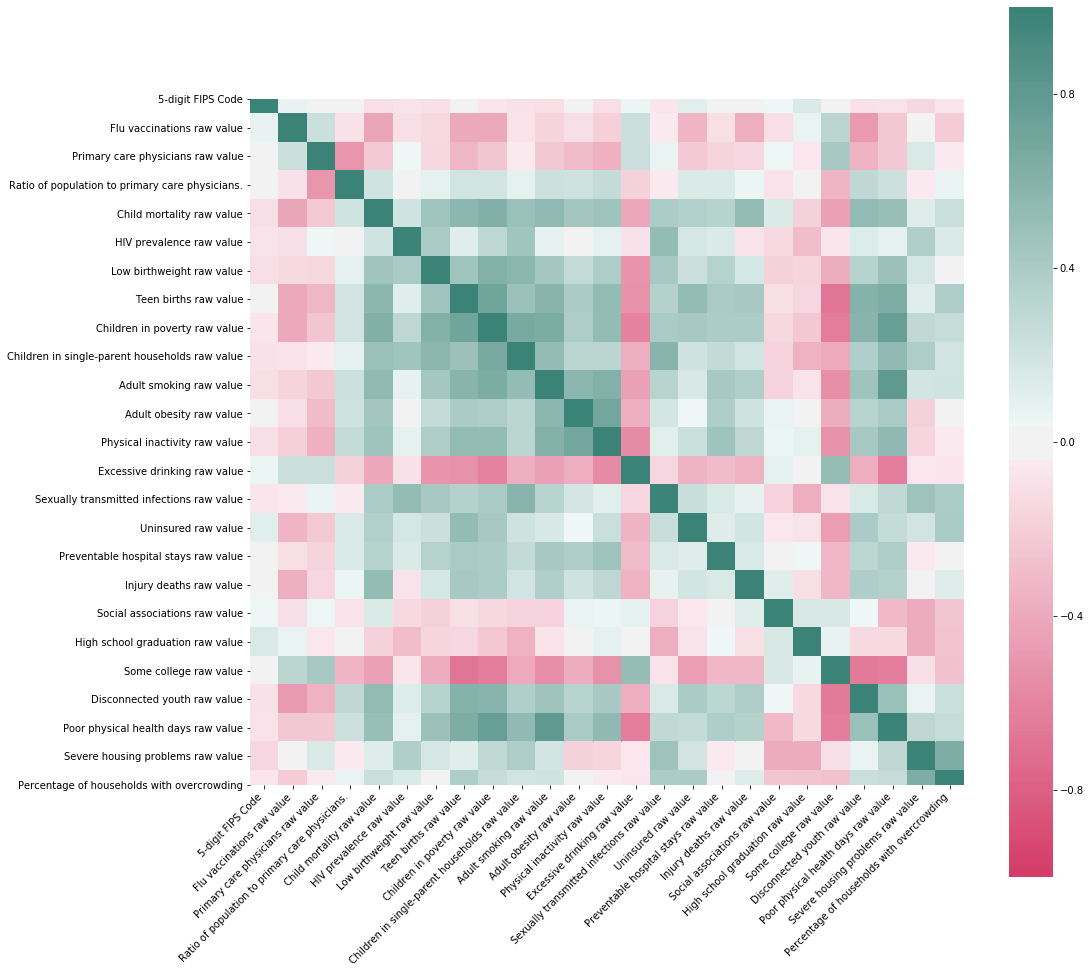

In [21]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(
    corr_matrix2, 
    vmin=-1, vmax=1, center=0, 
    cmap=sns.diverging_palette(0,534,n=534),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

In [22]:
df_relevant_list = ['Primary care physicians raw value' , 'Ratio of population to primary care physicians.' , 
              'Child mortality raw value' , 'HIV prevalence raw value' , 'Low birthweight raw value' , 
              'Teen births raw value' , 'Children in poverty raw value' , 
              'Children in single-parent households raw value' , 'Adult smoking raw value' , 
              'Adult obesity raw value' , 'Physical inactivity raw value' , 'Excessive drinking raw value' , 
              'Sexually transmitted infections raw value' , 'Uninsured raw value' , 
              'Preventable hospital stays raw value' , 'Injury deaths raw value' , 'Social associations raw value' , 
              'High school graduation raw value' , 'Some college raw value' , 'Disconnected youth raw value' , 
              'Poor physical health days raw value' , 'Severe housing problems raw value' , 
              'Percentage of households with overcrowding']

In [23]:
y = pd.DataFrame(df_relevant['Flu vaccinations raw value'],columns = ['Flu vaccinations raw value'])
df_model = pd.DataFrame(df_relevant, columns = df_relevant_list)

In [25]:
df_religion = pd.read_excel ('US_religion_census_2010.xlsx')
df_religion.head()

,FIPS,STCODE,STABBR,STNAME,CNTYCODE,CNTYNAME,POP2010,TOTCNG,TOTADH,TOTRATE,EVANCNG,EVANADH,EVANRATE,BPRTCNG,BPRTADH,BPRTRATE,MPRTCNG,MPRTADH,MPRTRATE,CATHCNG,CATHADH,CATHRATE,ORTHCNG,ORTHADH,ORTHRATE,OTHCNG,OTHADH,OTHRATE,OCGCNG,AMECNG,AMEADH,AMERATE,AMEZCNG,AMEZADH,AMEZRATE,ALBCNG,ALBADH,ALBRATE,AWMCCNG,AWMCADH,AWMCRATE,ALBPCNG,AMANCNG,AMANADH,AMANRATE,AAMCNG,AAMADH,AAMRATE,AALCCNG,ABACNG,ABAADH,ABARATE,ABCCNG,ABCADH,ABCRATE,ACROCNG,ACROADH,ACRORATE,APCCNG,AMSHCNG,AMSHADH,AMSHRATE,ACNACNG,AOCACNG,AOCAADH,AOCARATE,ACCACNG,ACCAADH,ACCARATE,AFMCNG,AFMADH,AFMRATE,ALCACNG,AACACNG,AACAADH,AACARATE,ARMCNG,ARMADH,ARMRATE,AECCNG,AGCNG,AGADH,AGRATE,AGIFCNG,ARPCCNG,ARPCADH,ARPCRATE,AFLCCNG,AMCCNG,ARBCCNG,BAHCNG,BAHADH,BAHRATE,BAMCCNG,BAMCADH,BAMCRATE,BAMCNG,BAMADH,BAMRATE,BFCCNG,BFCADH,BFCRATE,BPCCNG,BCACNG,BCAADH,BCARATE,BCCCNG,BRUDCNG,BRUDADH,BRUDRATE,BUDMCNG,BUDMADH,BUDMRATE,BUDTCNG,BUDTADH,BUDTRATE,BUDVCNG,BUDVADH,BUDVRATE,BULGCNG,BULGADH,BULGRATE,CCFCCNG,CARCCNG,CTHCNG,CTHADH,CTHRATE,CYMFCNG,CYMFADH,CYMFRATE,CMACNG,CMAADH,CMARATE,CBCNG,CCDCCNG,CCDCADH,CCDCRATE,CCCCCNG,CCCCADH,CCCCRATE,CMECNG,CMEADH,CMERATE,CRCCNG,CRCADH,CRCRATE,CUCNG,CCHCNG,CCSCNG,CGAICNG,CGAIADH,CGAIRATE,CGCTCNG,CGCTADH,CGCTRATE,CG7DCNG,CGFCNG,CGGCCNG,CGGCADH,CGGCRATE,CGCCNG,CGCADH,CGCRATE,CGCMCNG,CGCMADH,CGCMRATE,CGPCNG,CGPADH,CGPRATE,CGAFCNG,CGMACNG,LDSCNG,LDSADH,LDSRATE,CAFCNG,CBRCNG,CBRADH,CBRRATE,CLBACNG,CLBAADH,CLBARATE,CLCCNG,NAZCNG,NAZADH,NAZRATE,CUBCCNG,CUBCADH,CUBCRATE,CHCHCNG,CHCHADH,CHCHRATE,CCCUCNG,CHGNCNG,CHGNADH,CHGNRATE,CRECCNG,COCCNG,COCADH,COCRATE,CCCCNG,CCCADH,CCCRATE,CHCCNG,CHCADH,CHCRATE,CMCCNG,CMCADH,CMCRATE,CBACNG,CCONCNG,CCONADH,CCONRATE,CJUDCNG,CJUDADH,CJUDRATE,CLACNG,CMCOCNG,CMCOADH,CMCORATE,CYFRCNG,CYFRADH,CYFRRATE,OFWBCNG,OFWBADH,OFWBRATE,CWCNG,CWADH,CWRATE,COPTCNG,COPTADH,COPTRATE,CRPCCNG,CUMBCNG,CUMBADH,CUMBRATE,CPCACNG,ELIMCNG,EBACNG,ECCNG,ECADH,ECRATE,EOCNG,EOADH,EORATE,ETHOCNG,EARCNG,EVCHCNG,ECCCNG,ECCADH,ECCRATE,ECOVCNG,ECOVADH,ECOVRATE,EFCACNG,EFCAADH,EFCARATE,EFCICNG,EFCIADH,EFCIRATE,ELCACNG,ELCAADH,ELCARATE,ELSCNG,ELSADH,ELSRATE,EMCCNG,EPCCNG,EPCADH,EPCRATE,FRCCNG,FEBCCNG,FEBCADH,FEBCRATE,FECCNG,FECADH,FECRATE,FOURCNG,FOURADH,FOURRATE,FCSCNG,FMCCNG,FMCADH,FMCRATE,FPCCNG,FRCHCNG,FRNDCNG,FRNDADH,FRNDRATE,FGCCNG,FGCADH,FGCRATE,FUMCNG,FUMADH,FUMRATE,FGBCNG,FBFCNG,GARBCNG,GOPCNG,GOPADH,GOPRATE,FGBCCNG,GGFCNG,GRKCNG,GRKADH,GRKRATE,HRCCNG,HRCADH,HRCRATE,HNICNG,HNIADH,HNIRATE,HNPRCNG,HNPRADH,HNPRRATE,HNRCNG,HNRADH,HNRRATE,HNTTCNG,HNTTADH,HNTTRATE,HOCCNG,HOCADH,HOCRATE,HUNGCNG,HUTTCNG,IBFICNG,IFCACNG,IYMFCNG,IYMFADH,IYMFRATE,ICCCNG,ICCADH,ICCRATE,ICCCCNG,IFBCCNG,INTFCNG,IPCCCNG,IPCCADH,IPCCRATE,IPHCCNG,IPHCADH,IPHCRATE,JAINCNG,JWCNG,KPRSCNG,KPCACNG,KAPCCNG,LCMSCNG,LCMSADH,LCMSRATE,LCMCCNG,LCMCADH,LCMCRATE,MOCCNG,MOCADH,MOCRATE,MALACNG,MALAADH,MALARATE,MOSCCNG,MOSCADH,MOSCRATE,MAMCNG,MAMADH,MAMRATE,MCFCNG,MCFADH,MCFRATE,MENNCNG,MENNADH,MENNRATE,MCCCNG,MCCADH,MCCRATE,MBAMCNG,MBAMADH,MBAMRATE,MCCFCNG,MCCFADH,MCCFRATE,MISSCNG,MISSADH,MISSRATE,MVAKCNG,MVAKADH,MVAKRATE,MVNOCNG,MVNOADH,MVNORATE,MVSOCNG,MVSOADH,MVSORATE,MSLMCNG,MSLMADH,MSLMRATE,NACCCNG,NACCADH,NACCRATE,FWBCNG,FWBADH,FWBRATE,NBCACNG,NBCAADH,NBCARATE,NBCCNG,NBCADH,NBCRATE,NMBCCNG,NMBCADH,NMBCRATE,NSACCNG,NWAPCNG,IBCCNG,NONDCNG,NONDADH,NONDRATE,NABCCNG,NABCADH,NABCRATE,NALCCNG,OORBCNG,OORBADH,OORBRATE,OBSCCNG,OBSCADH,OBSCRATE,OCACNG,OCAADH,OCARATE,OJUDCNG,OJUDADH,OJUDRATE,OPCCNG,OPCADH,OPCRATE,ROCCNG,ROCADH,ROCRATE,PCCCNG,PCCADH,PCCRATE,FBHCCNG,PFWBCNG,PILLCNG,PILLADH,PILLRATE,PNCCCNG,PCCNG,PCADH,PCRATE,PCACNG,PCAADH,PCARATE,PRCCNG,PBEDCNG,PBEDADH,PBEDRATE,PMCCNG,PNBCCNG,PNBCADH,PNBCRATE,PRCACNG,PRCAADH,PRCARATE,RJUDCNG,RJUDADH,RJUDRATE,RFRMCNG,RFRMADH,RFRMRATE,RBCCNG,RCACNG,RCAADH,RCARATE,RCUSCNG,RCUSADH,RCUSRATE,RMCCNG,RMCADH,RMCRATE,RPCCNGV,RPHPCNG,RPUSCNG,RPNACNG,RPNAADH,RPNARATE,ROAACNG,ROAAADH,ROAARATE,ROORCNG,ROORADH,ROORRATE,SALVCNG,SALVADH,SALVRATE,SCHWCNG,SCHWADH,SCHWRATE,SERBCNG,SERBADH,SERBRATE,SDBCNG,SDBADH,SDBRATE,SDACCNG,SDACADH,SDACRATE,SHNTCNG,SIKHCNG,SBCCNG,SBCAD

In [29]:
df_religion = df_religion[['FIPS' , 'STCODE' , 'STABBR' ,'STNAME' , 'CNTYNAME' , 'POP2010' , 'EVANRATE' , 'BPRTRATE' , 'MPRTRATE' , 'CATHRATE' , 'ABARATE' , 'ABCRATE' , 'LDSRATE' , 'RJUDRATE' , 'RFRMRATE' , 'MSLMRATE']]

df_religion.head()


,FIPS,STCODE,STABBR,STNAME,CNTYNAME,POP2010,EVANRATE,BPRTRATE,MPRTRATE,CATHRATE,ABARATE,ABCRATE,LDSRATE,RJUDRATE,RFRMRATE,MSLMRATE
0,1001.0,1.0,AL,Alabama,Autauga County,54571.0,503.990000,41.978889,82.858889,32.358889,3.45,NaN,15.028889,NaN,NaN,NaN
1,1003.0,1.0,AL,Alabama,Baldwin County,182265.0,318.138889,17.170000,110.140000,76.858889,1.00,NaN,5.610000,NaN,NaN,NaN
2,1005.0,1.0,AL,Alabama,Barbour County,27457.0,320.250000,121.208889,77.938889,20.940000,NaN,NaN,9.650000,NaN,NaN,NaN
3,1007.0,1.0,AL,Alabama,Bibb County,22915.0,443.328889,42.158889,13.178889,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1009.0,1.0,AL,Alabama,Blount County,57322.0,509.800000,1.010000,52.950000,82.760000,NaN,NaN,5.080000,NaN,NaN,NaN


## Merging religion dataframe.

In [24]:
df_religion = pd.read_excel ('US_religion_census_2010.xlsx')
df_religion = df_religion[['FIPS','CATHRATE']]
df_religion.set_index('FIPS', inplace=True)
df_religion.head()

,CATHRATE
FIPS,
1001.0,32.358889
1003.0,76.858889
1005.0,20.940000
1007.0,NaN
1009.0,82.760000


In [25]:
len(df_religion)

3150

In [26]:
df_relevant_religion = df_relevant.merge(df_religion, left_on='5-digit FIPS Code', right_on='FIPS')

In [27]:
len(df_relevant_religion)

3140

In [28]:
df_relevant_religion.head()

,State Abbreviation,Name,5-digit FIPS Code,Flu vaccinations raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding,CATHRATE
0,AL,Autauga County,1001.0,0.41,0.000415,2409.391304,53.279441,225.5,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516,32.358889
1,AL,Baldwin County,1003.0,0.45,0.000729,1372.125000,47.000017,163.9,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728,76.858889
2,AL,Barbour County,1005.0,0.37,0.000385,2596.500000,77.080027,436.0,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065,20.940000
3,AL,Bibb County,1007.0,0.39,0.000574,1741.769231,111.749681,191.9,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,NaN,4.363377,0.109609,0.001993,NaN
4,AL,Blount County,1009.0,0.38,0.000225,4438.769231,76.032935,95.4,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247,82.760000


In [29]:
df_relevant_religion['CATHRATE'] = df_relevant_religion['CATHRATE']/100

In the cells below we create another dataframe and group the counties by state. The mean of each state variable is taken.

In [30]:
df_state_group = df_relevant_religion

In [31]:
cols = df_state_group.columns
cols_included = list(filter(lambda col: col != 'State Abbreviation' and col != 'Name', cols))

for col in cols_included:
    df_state_group[col] = df_state_group[col].astype(float)

In [32]:
df_state_group = df_state_group.groupby(['State Abbreviation']).median()

From this we can then find the 10 states with the highest and lowest flu vaccine rates.

In [33]:
df_state_group = df_state_group.sort_values(by='Flu vaccinations raw value', ascending=True)
df_state_group = df_state_group['Flu vaccinations raw value']
df_lowest_state_group = df_state_group.to_frame().head(10)
df_highest_state_group = df_state_group.to_frame().tail(10)

In [34]:
df_relevant_religion.head()

,State Abbreviation,Name,5-digit FIPS Code,Flu vaccinations raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding,CATHRATE
0,AL,Autauga County,1001.0,0.41,0.000415,2409.391304,53.279441,225.5,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516,0.323589
1,AL,Baldwin County,1003.0,0.45,0.000729,1372.125000,47.000017,163.9,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728,0.768589
2,AL,Barbour County,1005.0,0.37,0.000385,2596.500000,77.080027,436.0,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065,0.209400
3,AL,Bibb County,1007.0,0.39,0.000574,1741.769231,111.749681,191.9,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,NaN,4.363377,0.109609,0.001993,NaN
4,AL,Blount County,1009.0,0.38,0.000225,4438.769231,76.032935,95.4,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247,0.827600


In [35]:
list_county_names = list(df_relevant_religion['Name'])
df_relevant_religion.drop(columns=['Name'], inplace=True)

In [36]:
df_relevant_religion.iloc[:,1:] = df_relevant_religion.groupby("State Abbreviation").transform(lambda x: x.fillna(x.median()))


In [37]:
df_relevant_religion['Name'] = list_county_names

In [38]:
df_relevant_religion

,State Abbreviation,5-digit FIPS Code,Flu vaccinations raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding,CATHRATE,Name
0,AL,1001.0,0.41,0.000415,2409.391304,53.279441,225.50,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516,0.323589,Autauga County
1,AL,1003.0,0.45,0.000729,1372.125000,47.000017,163.90,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728,0.768589,Baldwin County
2,AL,1005.0,0.37,0.000385,2596.500000,77.080027,436.00,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065,0.209400,Barbour County
3,AL,1007.0,0.39,0.000574,1741.769231,111.749681,191.90,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,0.097104,4.363377,0.109609,0.001993,0.154000,Bibb County
4,AL,1009.0,0.38,0.000225,4438.769231,76.032935,95.40,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247,0.827600,Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,WY,56037.0,0.37,0.000340,2944.333333,37.845339,86.50,0.094205,34.261671,0.134,0.234619,0.175669,0.302,0.256,0.203251,221.8,0.127509,3289.0,85.365634,9.962640,0.800676,0.592955,0.054410,3.536556,0.095923,0.029976,1.599600,Sweetwater County
3136,WY,56039.0,0.47,0.001207,828.250000,58.801791,50.50,0.074739,11.641444,0.069,0.240426,0.141373,0.136,0.120,0.204511,436.8,0.149793,2341.0,61.858005,18.110474,0.934641,0.820042,0.054410,3.166316,0.161271,0.035431,0.656089,Teton County
3137,WY,56041.0,0.33,0.000385,2596.625000,58.801791,49.65,0.096475,31.798673,0.118,0.216457,0.181806,0.318,0.235,0.160586,288.2,0.125690,3140.0,98.020373,5.295335,0.846875,0.558918,0.054410,3.677538,0.111333,0.027200,0.380200,Uinta County
3138,WY,56043.0,0.43,0.000486,2058.750000,58.801791,49.65,0.073209,27.649770,0.140,0.266296,0.156076,0.297,0.260,0.163430,252.2,0.167082,4330.0,70.028011,19.429265,0.862903,0.601322,0.054410,3.601687,0.105413,0.024217,0.948100,Washakie County


In [39]:
names = df_relevant_religion['Name']
df_relevant_religion.drop(labels=['Name'], axis=1,inplace = True)
df_relevant_religion.insert(2, 'Name', names)
df_relevant_religion.set_index('Name')

,State Abbreviation,5-digit FIPS Code,Flu vaccinations raw value,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding,CATHRATE
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
Autauga County,AL,1001.0,0.41,0.000415,2409.391304,53.279441,225.50,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516,0.323589
Baldwin County,AL,1003.0,0.45,0.000729,1372.125000,47.000017,163.90,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728,0.768589
Barbour County,AL,1005.0,0.37,0.000385,2596.500000,77.080027,436.00,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065,0.209400
Bibb County,AL,1007.0,0.39,0.000574,1741.769231,111.749681,191.90,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,0.097104,4.363377,0.109609,0.001993,0.154000
Blount County,AL,1009.0,0.38,0.000225,4438.769231,76.032935,95.40,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247,0.827600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sweetwater County,WY,56037.0,0.37,0.000340,2944.333333,37.845339,86.50,0.094205,34.261671,0.134,0.234619,0.175669,0.302,0.256,0.203251,221.8,0.127509,3289.0,85.365634,9.962640,0.800676,0.592955,0.054410,3.536556,0.095923,0.029976,1.599600
Teton County,WY,56039.0,0.47,0.001207,828.250000,58.801791,50.50,0.074739,11.641444,0.069,0.240426,0.141373,0.136,0.120,0.204511,436.8,0.149793,2341.0,61.858005,18.110474,0.934641,0.820042,0.054410,3.166316,0.161271,0.035431,0.656089
Uinta County,WY,56041.0,0.33,0.000385,2596.625000,58.801791,49.65,0.096475,31.798673,0.118,0.216457,0.181806,0.318,0.235,0.160586,288.2,0.125690,3140.0,98.020373,5.295335,0.846875,0.558918,0.054410,3.677538,0.111333,0.027200,0.380200


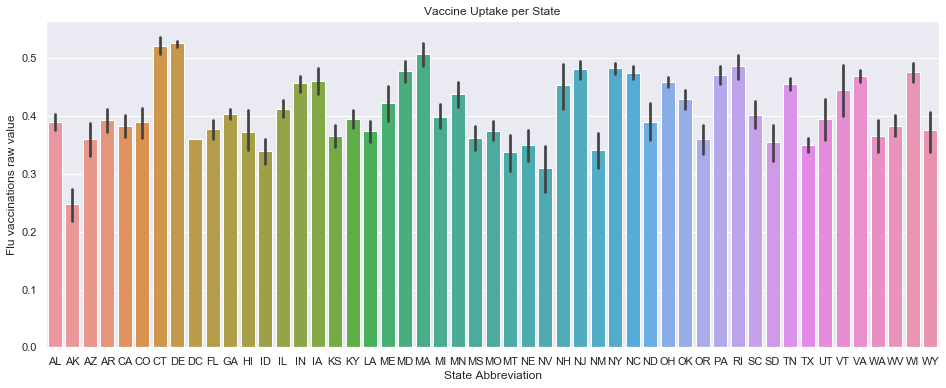

In [64]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="State Abbreviation", y="Flu vaccinations raw value" , data=df_relevant_religion).set_title("Vaccine Uptake per State")

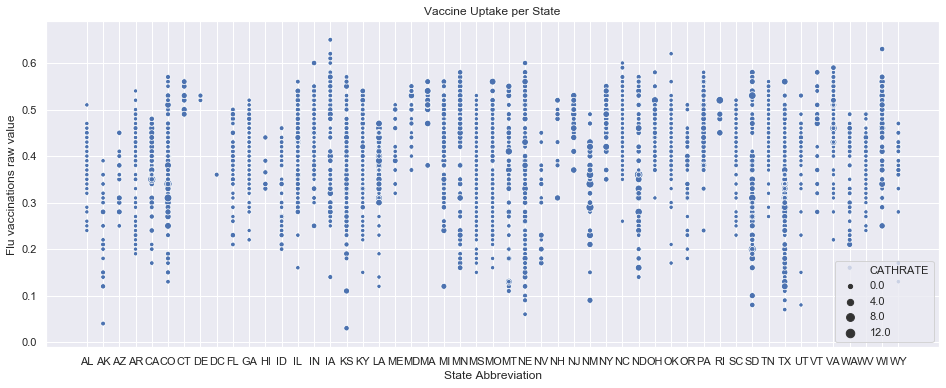

In [62]:
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="State Abbreviation", y="Flu vaccinations raw value", 
                     size = 'CATHRATE' , data=df_relevant_religion).set_title("Vaccine Uptake per State")

In [83]:
sns.set()
plt.figure(figsize=(16, 6))
vaccines = df_relevant_religion.pivot("Name", "Flu vaccinations raw value", "CATHRATE")
ax = sns.heatmap(vaccines)


ValueError: Index contains duplicate entries, cannot reshape

<Figure size 1152x432 with 0 Axes>

In [59]:
df_relevant_religion2 = df_relevant_religion.iloc[:,3:]

In [42]:
y = df_relevant_religion2['Flu vaccinations raw value']
X = df_relevant_religion2.drop(columns='Flu vaccinations raw value', axis=1)

In [43]:
# Get column names first
names = df_relevant_religion.columns[4:]
df_to_be_scaled = df_relevant_religion.iloc[:,4:]
# # Create the Scaler object
# scaler = preprocessing.StandardScaler()
# # Fit your data on the scaler object
# scaled_df = scaler.fit_transform(df)
# scaled_df = pd.DataFrame(scaled_df, columns=names)

In [44]:
df_to_be_scaled

,Primary care physicians raw value,Ratio of population to primary care physicians.,Child mortality raw value,HIV prevalence raw value,Low birthweight raw value,Teen births raw value,Children in poverty raw value,Children in single-parent households raw value,Adult smoking raw value,Adult obesity raw value,Physical inactivity raw value,Excessive drinking raw value,Sexually transmitted infections raw value,Uninsured raw value,Preventable hospital stays raw value,Injury deaths raw value,Social associations raw value,High school graduation raw value,Some college raw value,Disconnected youth raw value,Poor physical health days raw value,Severe housing problems raw value,Percentage of households with overcrowding,CATHRATE
0,0.000415,2409.391304,53.279441,225.50,0.084757,26.524208,0.193,0.247001,0.191247,0.375,0.311,0.168780,341.2,0.085010,6599.0,74.031808,12.631731,0.900000,0.608547,0.080117,4.200578,0.149546,0.024516,0.323589
1,0.000729,1372.125000,47.000017,163.90,0.083387,29.594009,0.147,0.251841,0.167955,0.310,0.238,0.167150,338.8,0.106993,3833.0,69.374289,10.692213,0.863616,0.661339,0.078257,4.098748,0.138317,0.010728,0.768589
2,0.000385,2596.500000,77.080027,436.00,0.109526,45.092838,0.503,0.572157,0.215409,0.443,0.282,0.126987,557.9,0.125132,4736.0,72.900134,8.472944,0.814103,0.367740,0.120448,5.067438,0.154555,0.020065,0.209400
3,0.000574,1741.769231,111.749681,191.90,0.111050,45.454545,0.273,0.295654,0.199164,0.378,0.349,0.159252,302.1,0.096801,5998.0,100.077937,10.157665,0.837638,0.484063,0.097104,4.363377,0.109609,0.001993,0.154000
4,0.000225,4438.769231,76.032935,95.40,0.079268,35.600555,0.185,0.295697,0.196522,0.344,0.285,0.153787,114.3,0.121140,4162.0,105.197227,9.011507,0.934688,0.544140,0.151055,4.512753,0.104012,0.017247,0.827600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,0.000340,2944.333333,37.845339,86.50,0.094205,34.261671,0.134,0.234619,0.175669,0.302,0.256,0.203251,221.8,0.127509,3289.0,85.365634,9.962640,0.800676,0.592955,0.054410,3.536556,0.095923,0.029976,1.599600
3136,0.001207,828.250000,58.801791,50.50,0.074739,11.641444,0.069,0.240426,0.141373,0.136,0.120,0.204511,436.8,0.149793,2341.0,61.858005,18.110474,0.934641,0.820042,0.054410,3.166316,0.161271,0.035431,0.656089
3137,0.000385,2596.625000,58.801791,49.65,0.096475,31.798673,0.118,0.216457,0.181806,0.318,0.235,0.160586,288.2,0.125690,3140.0,98.020373,5.295335,0.846875,0.558918,0.054410,3.677538,0.111333,0.027200,0.380200
3138,0.000486,2058.750000,58.801791,49.65,0.073209,27.649770,0.140,0.266296,0.156076,0.297,0.260,0.163430,252.2,0.167082,4330.0,70.028011,19.429265,0.862903,0.601322,0.054410,3.601687,0.105413,0.024217,0.948100
